In [1]:
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.covariance import GraphicalLasso
from tqdm.auto import tqdm

plt.style.use('ggplot')

/home/mlauber/miniconda3/envs/mci_mri_graph/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


this doesn't have bootstrapping (so add this code to the cent_pop_ggm_boostrap_bic_vis notebook)

In [2]:
# data = pd.read_csv("construct_ggm/pet_graphs/amy_pos_reg_dropleftright.csv",index_col=0) #demo one matteo used
data = pd.read_csv("construct_ggm/pet_graphs/adni/adni_amy_tau_merged_cent_high_quartile.csv",index_col=0)
data.sample(3)

,SUPRAMARGINAL,AMYGDALA,MIDDLETEMPORAL,PARSOPERCULARIS,CAUDALANTERIORCINGULATE,INSULA,MEDIALORBITOFRONTAL,ENTORHINAL,PUTAMEN,PERICALCARINE,...,POSTERIORCINGULATE,SUPERIORTEMPORAL,FUSIFORM,PARACENTRAL,CEREBELLUM_CORTEX,PARAHIPPOCAMPAL,BANKSSTS,POSTCENTRAL,HIPPOCAMPUS,SUPERIORFRONTAL
RID,,,,,,,,,,,,,,,,,,,,,
4507,1.361,2.136,1.928,1.290,1.081,1.150,1.245,1.764,1.585,0.769,...,1.279,1.316,2.496,1.130,0.997,1.864,1.519,1.014,1.398,1.283
626,1.455,1.604,1.960,1.307,1.152,1.395,1.274,2.295,2.109,0.905,...,1.480,1.423,1.874,0.990,1.000,1.969,1.129,1.018,1.229,1.307
6600,1.551,2.157,2.538,1.397,1.118,1.560,1.463,1.991,1.781,1.349,...,1.377,1.719,2.471,1.058,1.006,1.589,2.066,1.221,1.766,1.372


In [4]:
print(data['HIPPOCAMPUS'].max())
print(data['HIPPOCAMPUS'].min())

2.292
0.862


In [21]:
#check if centiloids col is there and drop it 
# data["CENTILOIDS"]
data = data.drop(columns="CENTILOIDS")
print(data.columns)

Index(['SUPRAMARGINAL', 'AMYGDALA', 'MIDDLETEMPORAL', 'PARSOPERCULARIS',
       'CAUDALANTERIORCINGULATE', 'INSULA', 'MEDIALORBITOFRONTAL',
       'ENTORHINAL', 'PUTAMEN', 'PERICALCARINE', 'ROSTRALANTERIORCINGULATE',
       'PRECUNEUS', 'THALAMUS', 'CAUDALMIDDLEFRONTAL', 'ACCUMBENS_AREA',
       'ISTHMUSCINGULATE', 'FRONTALPOLE', 'PARSTRIANGULARIS',
       'ROSTRALMIDDLEFRONTAL', 'SUPERIORPARIETAL', 'CAUDATE', 'LINGUAL',
       'LATERALORBITOFRONTAL', 'LATERALOCCIPITAL', 'PARSORBITALIS',
       'VENTRALDC', 'PRECENTRAL', 'TEMPORALPOLE', 'INFERIORPARIETAL',
       'TRANSVERSETEMPORAL', 'CUNEUS', 'PALLIDUM', 'INFERIORTEMPORAL',
       'POSTERIORCINGULATE', 'SUPERIORTEMPORAL', 'FUSIFORM', 'PARACENTRAL',
       'CEREBELLUM_CORTEX', 'PARAHIPPOCAMPAL', 'BANKSSTS', 'POSTCENTRAL',
       'HIPPOCAMPUS', 'SUPERIORFRONTAL'],
      dtype='object')


In [22]:
scaler = StandardScaler()
scaler.set_output(transform='pandas')

data_scaled = scaler.fit_transform(data)

difference between the sklearn graphical lasso and graphical lasso cv model is that for the regular you specify the regularization paramter (alpha) and for the cv it is using cross validation to find the optimal alpha. That's why the cv model took so long to run and was throwing all the errors 

sklearn has a bunch of different model paramters that I can play around with, so could potentially adjust those 
- already using mode, tol, max_iter, assume_centered but still more parameters/attributes to use 
- maybe could play around with enet_tol parameter. It uses elastic net solver to calculate gradient direction 
- 

In [23]:
model = GraphicalLasso(alpha=0.6, 
                       max_iter=100, 
                       tol=1e-2, 
                       mode='cd', #default is LARS, but cd is more numerically stable 
                       assume_centered=True) #because data is normalized 

model.fit(data_scaled)

GraphicalLasso(alpha=0.6, assume_centered=True, tol=0.01)

In [24]:
alphas = np.linspace(0.015,1.,64)
precision_sparsities = []
covariance_sparsities = []

for alpha in tqdm(alphas): 
    
    model = GraphicalLasso(alpha=alpha, max_iter=1000, tol=1e-2, mode='cd', eps=1e-12, assume_centered=True)
    model.fit(data_scaled)

    precision_sparsities.append(np.count_nonzero(model.precision_)/(model.precision_.size))
    covariance_sparsities.append(np.count_nonzero(model.covariance_)/(model.covariance_.size))

  0%|          | 0/64 [00:00<?, ?it/s]/home/mlauber/miniconda3/envs/mci_mri_graph/lib/python3.10/site-packages/sklearn/covariance/_graph_lasso.py:183: ConvergenceWarning: graphical_lasso: did not converge after 1000 iteration: dual gap: 1.803e-01
  warnings.warn(
100%|██████████| 64/64 [00:04<00:00, 13.33it/s]


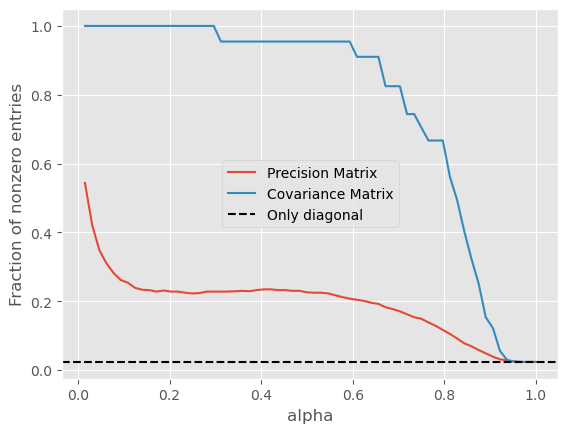

In [25]:
plt.plot(alphas,precision_sparsities,label="Precision Matrix")
plt.plot(alphas,covariance_sparsities,label="Covariance Matrix")
plt.xlabel("alpha")
plt.ylabel("Fraction of nonzero entries")
plt.axhline(1/model.covariance_.shape[0],color='k',linestyle='--',label="Only diagonal")
plt.legend()

# Make graphs

In [26]:
model = GraphicalLasso(alpha=0.7, max_iter=1000, tol=1e-2, mode='cd', eps=1e-12, assume_centered=True)
model.fit(data_scaled)

GraphicalLasso(alpha=0.7, assume_centered=True, eps=1e-12, max_iter=1000,
               tol=0.01)

Text(0.5, 1.0, 'Covariance')

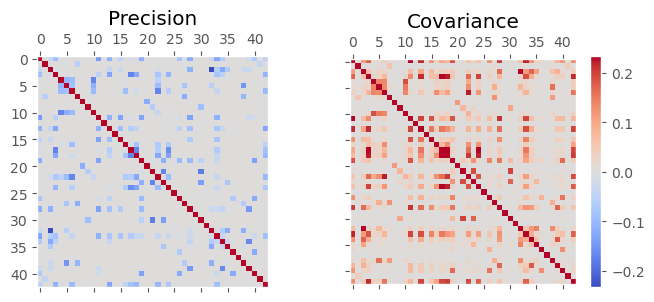

In [27]:
fig,axs = plt.subplots(1,2,figsize=(8,3),sharey=True)

im = axs[0].matshow(model.precision_,cmap='coolwarm',vmin=model.precision_.min(),vmax=-model.precision_.min())
axs[0].grid()
# plt.colorbar(im,ax=axs[0])
axs[0].set_title("Precision")
# axs[0].axis('off')

im = axs[1].matshow(model.covariance_,cmap='coolwarm',vmin=model.precision_.min(),vmax=-model.precision_.min())
axs[1].grid()
plt.colorbar(im,ax=axs[1])
axs[1].set_title("Covariance")
# axs[1].axis('off')

In [28]:
adj = np.copy(model.precision_)

np.fill_diagonal(adj, 0) # remove self connections 

G = nx.Graph(adj)

node_labels = {i: label.rsplit('_',1)[0] for i, label in enumerate(data_scaled.columns)}

G = nx.relabel_nodes(G, node_labels)


In [29]:
#print degrees from highest to lowest 
#first convert to a list of tuples and then sort from highest to lowest 
highest_deg = sorted(G.degree(), key=lambda x: x[1], reverse=True)
print(highest_deg)

[('POSTERIORCINGULATE', 18), ('SUPRAMARGINAL', 15), ('CAUDALMIDDLEFRONTAL', 13), ('MIDDLETEMPORAL', 12), ('PARSOPERCULARIS', 12), ('LATERALORBITOFRONTAL', 12), ('PRECUNEUS', 11), ('INFERIORPARIETAL', 11), ('SUPERIORFRONTAL', 11), ('MEDIALORBITOFRONTAL', 10), ('PARSTRIANGULARIS', 10), ('SUPERIORPARIETAL', 10), ('ROSTRALMIDDLEFRONTAL', 9), ('PARSORBITALIS', 9), ('SUPERIORTEMPORAL', 9), ('INSULA', 8), ('INFERIORTEMPORAL', 8), ('FRONTALPOLE', 7), ('PRECENTRAL', 7), ('CAUDALANTERIORCINGULATE', 6), ('ISTHMUSCINGULATE', 6), ('FUSIFORM', 6), ('PARAHIPPOCAMPAL', 6), ('BANKSSTS', 6), ('POSTCENTRAL', 6), ('AMYGDALA', 4), ('ROSTRALANTERIORCINGULATE', 4), ('LINGUAL', 4), ('LATERALOCCIPITAL', 4), ('TEMPORALPOLE', 4), ('CUNEUS', 4), ('ENTORHINAL', 3), ('PERICALCARINE', 2), ('PARACENTRAL', 2), ('PUTAMEN', 1), ('CAUDATE', 1), ('VENTRALDC', 1), ('PALLIDUM', 1), ('HIPPOCAMPUS', 1), ('THALAMUS', 0), ('ACCUMBENS', 0), ('TRANSVERSETEMPORAL', 0), ('CEREBELLUM', 0)]


In [30]:
# Create a colormap for node colors based on node degrees
# node_colors = list(node_degrees.values())

Identify and drop the nodes with no connections

In [31]:
isolates = list(nx.isolates(G))
isolates

['THALAMUS', 'ACCUMBENS', 'TRANSVERSETEMPORAL', 'CEREBELLUM']

In [32]:
G.remove_nodes_from(isolates)

In [33]:
connected_components = list(nx.connected_components(G))
len(connected_components)

3

/tmp/ipykernel_3027719/2838395939.py:26: DeprecationWarning: `alltrue` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `all` instead.
  nx.draw_networkx_edges(


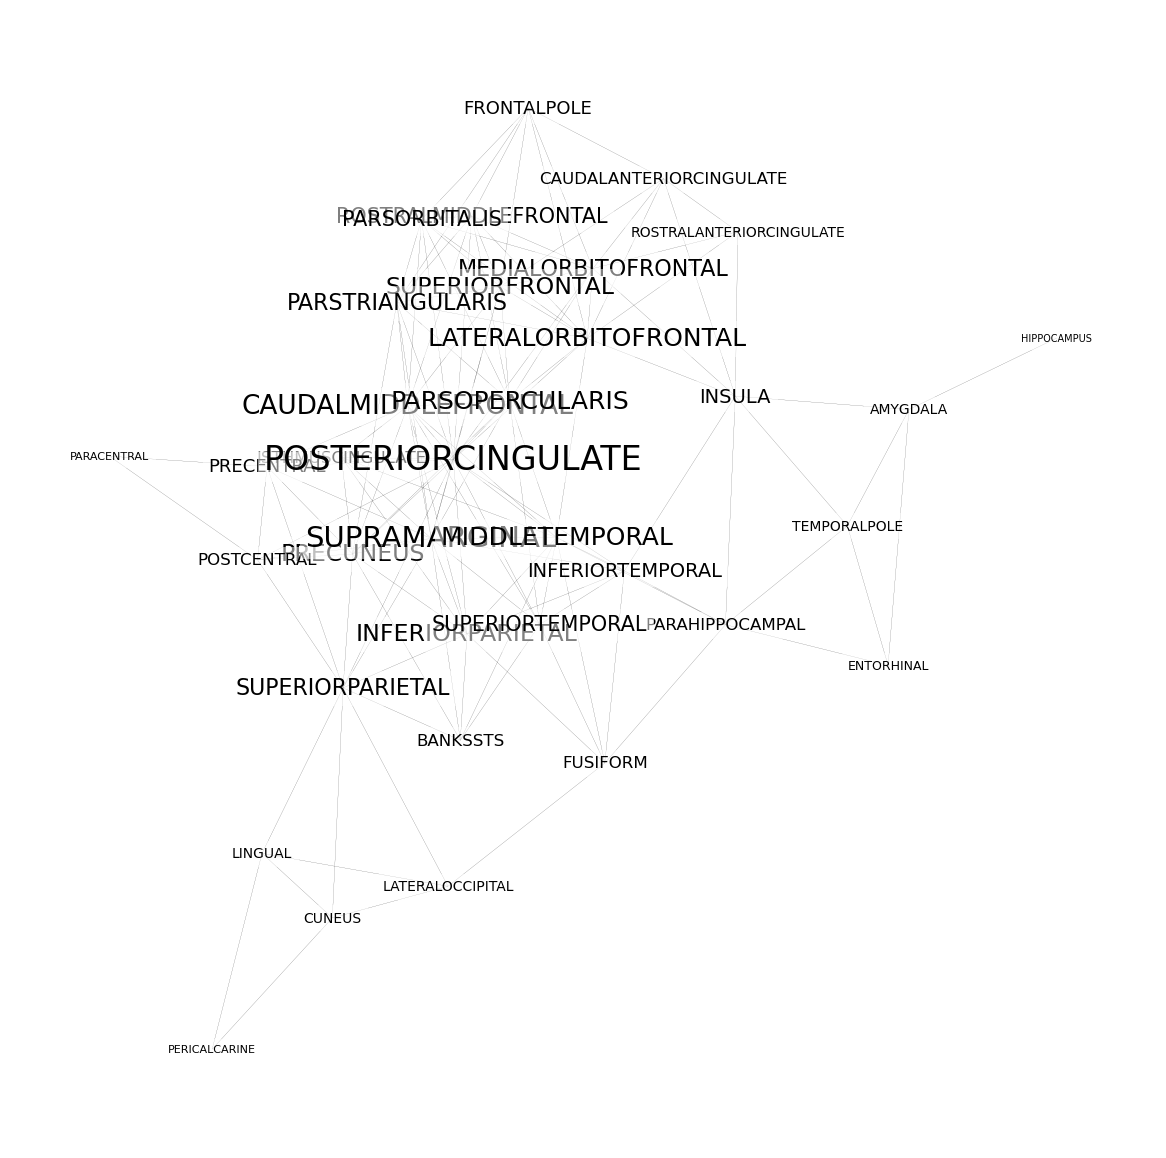

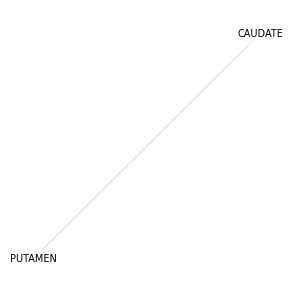

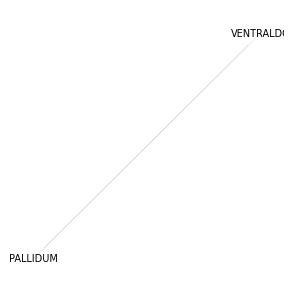

In [34]:
#  Draw the graph with node sizes and colors

for component in connected_components:

    g = G.subgraph(component)

    node_degrees = dict(g.degree())
    node_sizes = [64 * node_degrees[node] for node in g.nodes()]

    L = np.sqrt(len(component))*2.5

    fig,ax = plt.subplots(1,1,figsize=(L,L))
    pos = nx.circular_layout(g)
    pos = nx.kamada_kawai_layout(g,pos=pos,weight=None)
    # pos = nx.spring_layout(g,k=.6,pos=pos,weight=None)

    for node in component:
        nx.draw_networkx_labels(
            G.subgraph(node),
            pos={node:pos[node]},
            font_size=6+G.degree[node],
            bbox={'facecolor':'white','edgecolor':'white','alpha':0.5},
            ax=ax
        )

    nx.draw_networkx_edges(
        g,
        pos,
        width=0.1,
        # style='dashed',
        ax=ax
    )

    ax.axis('off');

# Identifying Hubs
- Examine nodes that are highly connected. 
- Identify nodes that are conditionally depedent (only connected through another region)

In [35]:
pos = nx.kamada_kawai_layout(G["POSTERIORCINGULATE"])

The following code shows node neighborhoods 
- If a node has more than one connection (degree>1), then it plots a subgraph of that node and it's connections 
- for conditional dependence, I should be looking for nodes where the central node 

* maybe change this plotting structure so that it is more intuitive, like instead of making a subplot for each amplifying node, include that node in the visualization 

/tmp/ipykernel_3027719/2507437277.py:22: DeprecationWarning: `alltrue` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `all` instead.
  nx.draw_networkx_edges(
/tmp/ipykernel_3027719/2507437277.py:5: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig,ax = plt.subplots(1,1,figsize=(6,4))


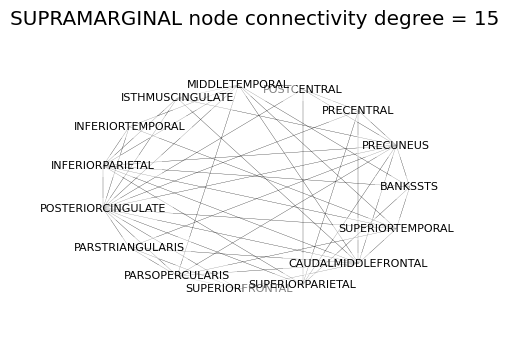

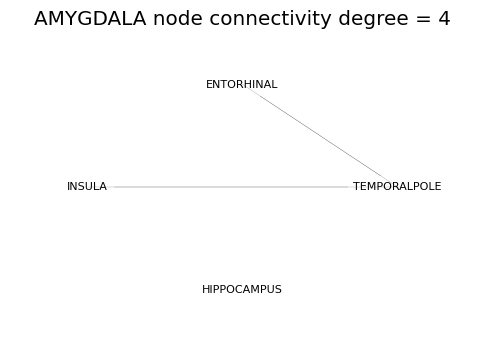

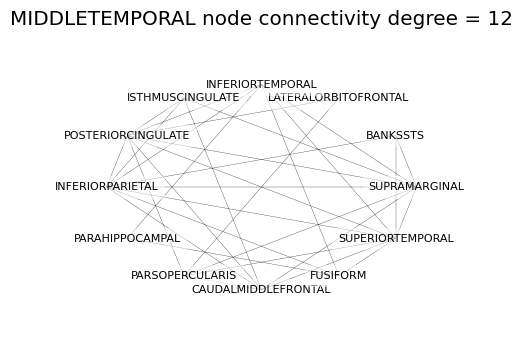

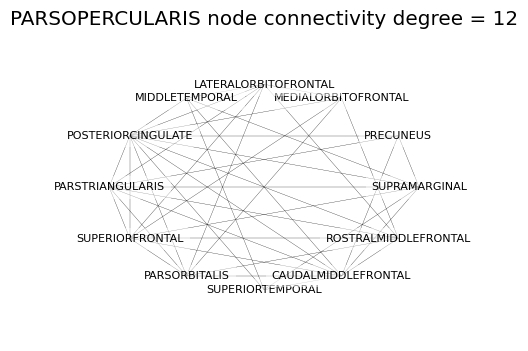

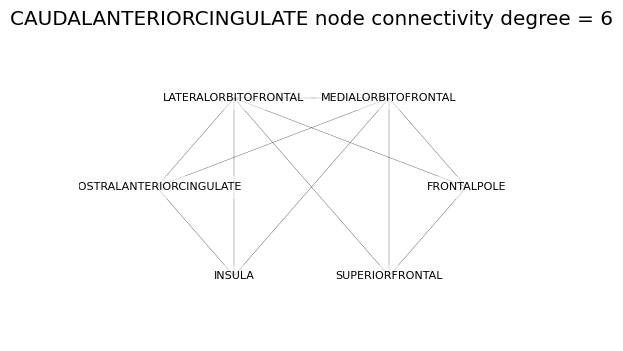

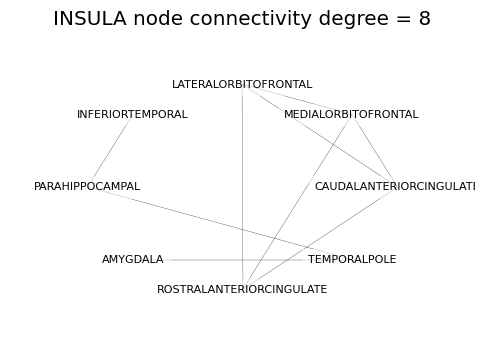

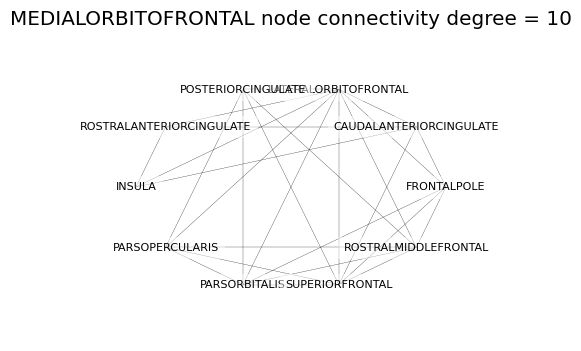

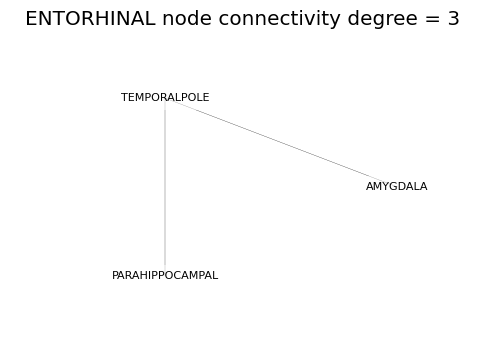

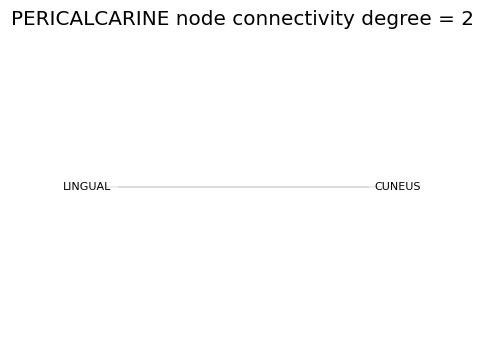

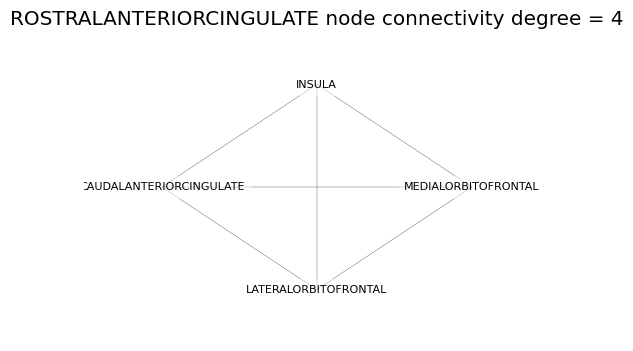

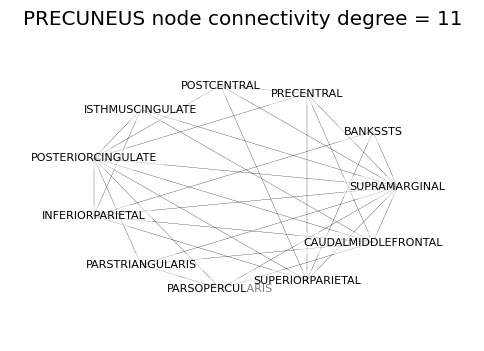

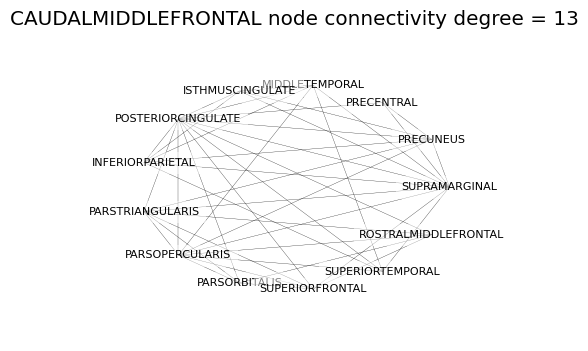

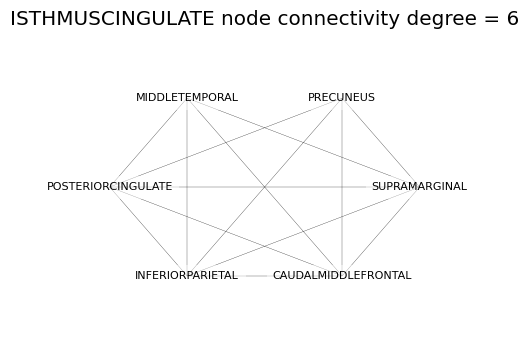

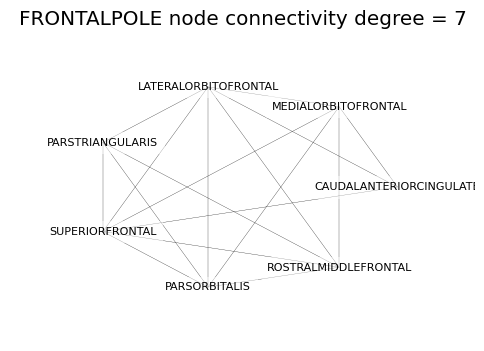

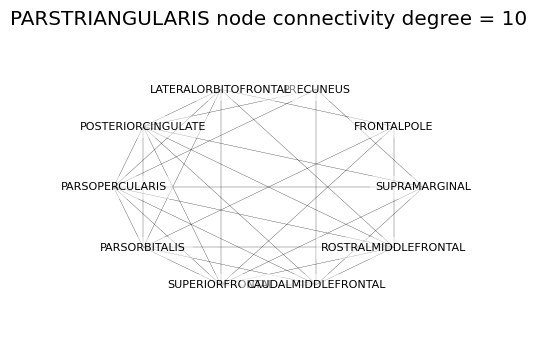

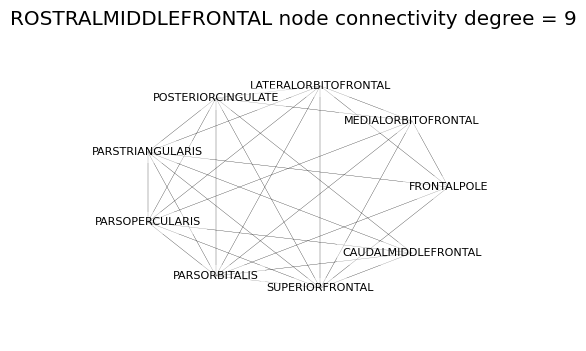

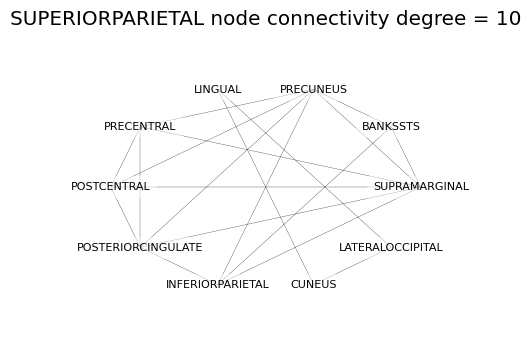

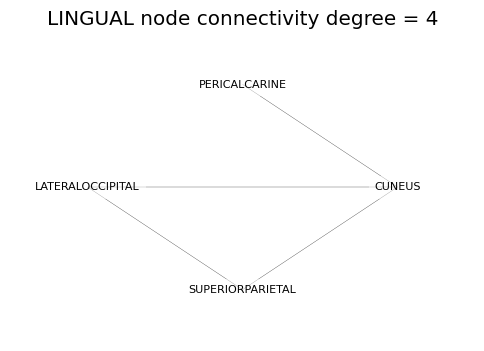

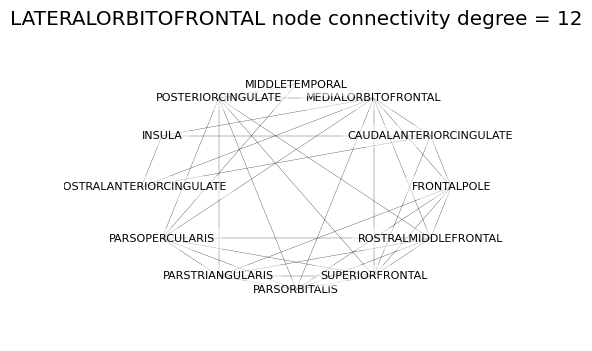

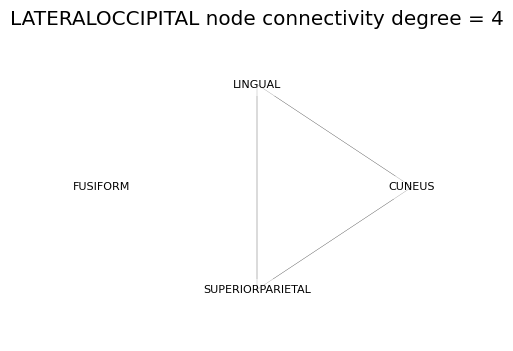

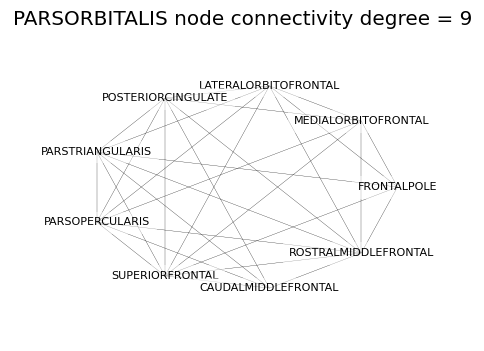

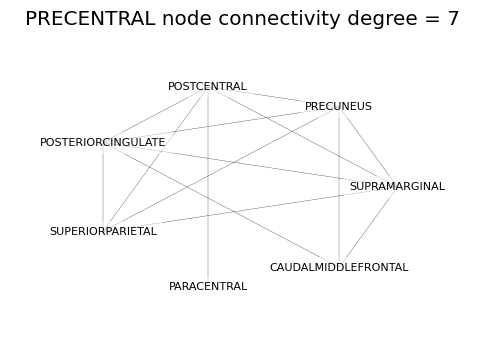

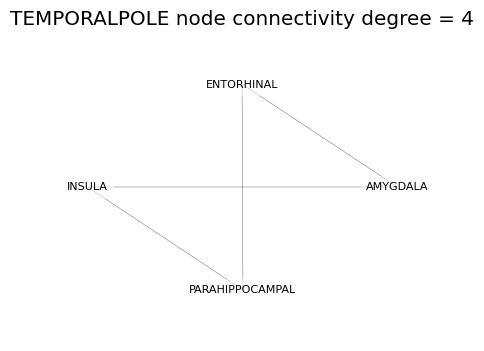

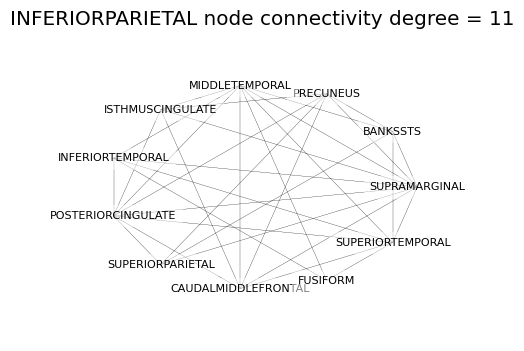

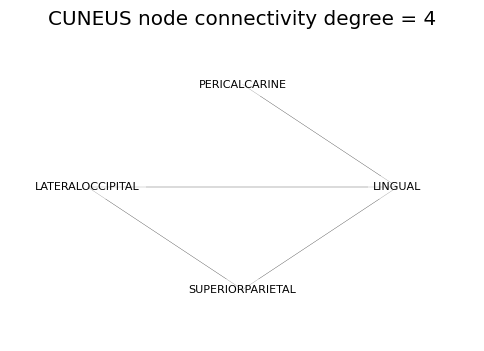

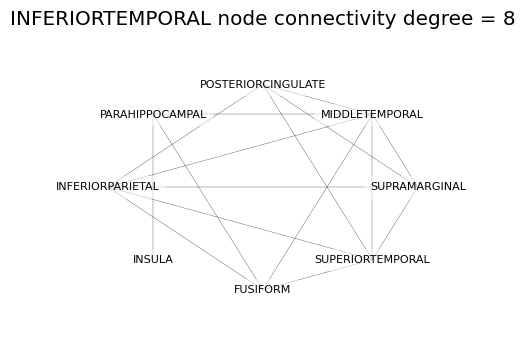

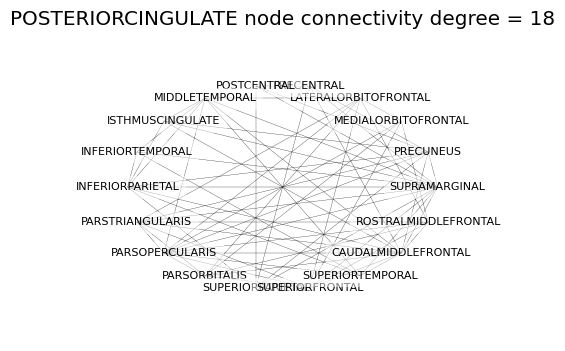

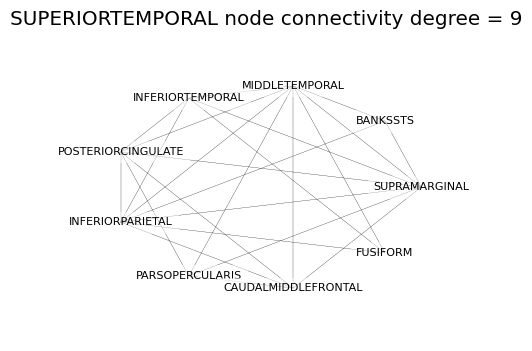

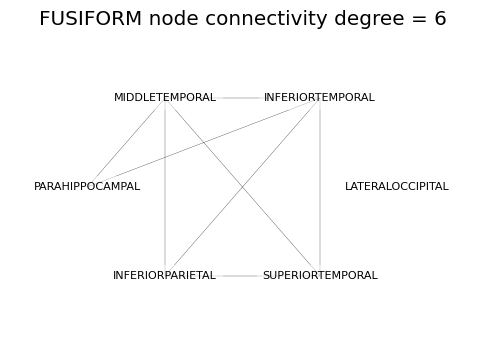

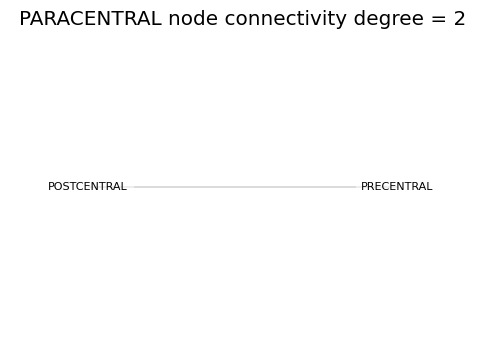

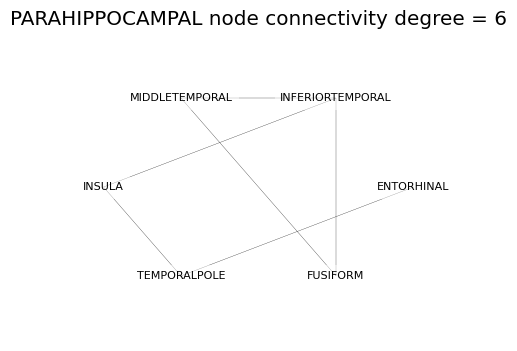

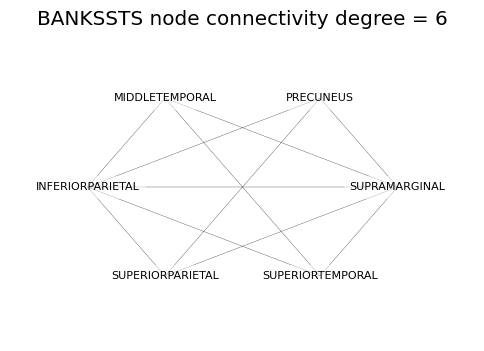

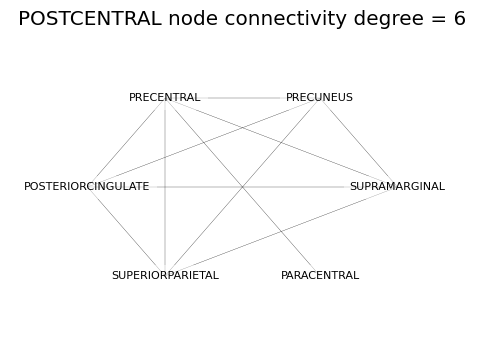

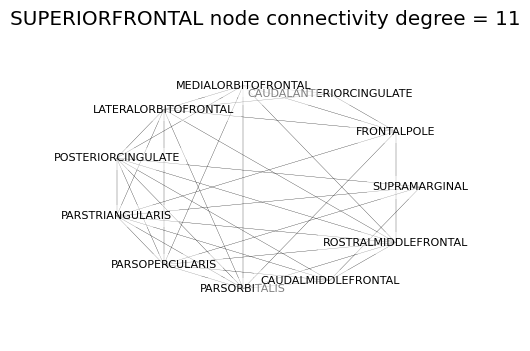

In [36]:
for node, degree in G.degree:
    
    if degree > 1:

        fig,ax = plt.subplots(1,1,figsize=(6,4))

        g = G.subgraph(G.neighbors(node))

        pos = nx.circular_layout(g)
        # pos = nx.kamada_kawai_layout(g,pos,weight=None)

        for n in g:
            nx.draw_networkx_labels(
                G.subgraph(n),
                pos={n:pos[n]},
                # font_size=6+G.degree[n],
                font_size=8,
                bbox={'facecolor':'white','edgecolor':'white','alpha':0.5},
                # ax=ax
            )

        nx.draw_networkx_edges(
            g,
            pos,
            width=.2,
            # style='dashed',
            # ax=ax
        )

        ax.set_xlim(left=-1.5,right=1.5)
        ax.set_ylim(bottom=-1.5,top=1.5)
        
        ax.set_title(node+" node connectivity degree = "+str(degree))
        ax.axis('off')